In [479]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import seaborn as sns
import os
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')
# nltk.download('wordnet')

# turn off the SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Define Path

In [465]:
DIR = os.getcwd()

# raw data
RAW = "\data\\raw"
PATH_DF_CHANNELS = DIR + RAW + '\df_channels_en.tsv.gz' # 6 mb
PATH_DF_TIMESERIES = DIR + RAW + '\df_timeseries_en.tsv.gz' # 571 mb
PATH_YT_METADATA = DIR + RAW + '\yt_metadata_en.jsonl.gz' # 13.6 gb
PATH_NUM_COMMENTS = DIR + RAW + '\num_comments.tsv.gz' # 754 mb

# clean data
CLEAN = "\data\\clean"
PATH_YT_TECH_METADATA = DIR + CLEAN + '\yt_tech_metadata_en.p'
PATH_TECH_CHANNELS = DIR + CLEAN + '\\tech_review_channels.p'
PATH_TECH_VIDEOS = DIR + CLEAN + '\\tech_review_videos.p'

# Filter Tech Review channels

### Metadata (filter 'Science & Education' videos)

In [4]:
# filter metadata
dfs = []
total_rows = 72924794
chunksize = 100000
for df_json in tqdm(pd.read_json(PATH_YT_METADATA, compression="infer", lines=True, chunksize=chunksize), desc='Loading data', total=total_rows/chunksize):
    df_json.drop(["description", "crawl_date"], inplace=True, axis=1)
    df_json = df_json[df_json['categories'] == 'Science & Technology']    
    df_json["upload_date"] = pd.to_datetime(df_json["upload_date"])
    
    dfs.append(df_json)
yt_metadata = pd.concat(dfs)
# yt_metadata.to_pickle(PATH_YT_TECH_METADATA,compression='gzip')

Loading data: 730it [48:15,  3.97s/it]                                                                                 


### Select most popular tech review channels' videos

In [47]:
# read channels dataset
df_channels = pd.read_csv(PATH_DF_CHANNELS, compression="infer", sep="\t")

# select the most popular tech review channels
popular_tech_channels = ['Marques Brownlee','Mrwhosetheboss','iJustine','UrAvgConsumer',
                         'Unbox Therapy','Linus Tech Tips','The Tech Chap','MrMobile [Michael Fi...']
popular_tech_channels_id = df_channels[df_channels.name_cc.isin(popular_tech_channels)].channel.unique()

# select the videos of the most popular tech review channels
popular_tech_channels_videos = yt_metadata[yt_metadata.channel_id.isin(popular_tech_channels_id)][['tags','title']]

### Find the most commonly used words both in tags and titles

In [330]:
def clean_text(text_data):
    text_data = text_data.lower()
    text_data = re.sub(r'[^a-z]', ' ', text_data)
    text_data = text_data.split()
    wl = WordNetLemmatizer()
    text_data_lem = [wl.lemmatize(word) for word in text_data if not word in set(stopwords.words('english'))]
    text_data_clean = [word for word in text_data_lem if len(word)>1]
    return text_data_clean

In [332]:
# clean title and tags features
popular_tech_channels_videos['clean_title'] = popular_tech_channels_videos.title.apply(clean_text)
popular_tech_channels_videos['clean_tags'] = popular_tech_channels_videos.tags.apply(clean_text)

# create a single list for all the words in both tags and titles
all_tags = []
all_titles = []
for tags in popular_tech_channels_videos.clean_tags.values:
    all_tags += tags
for titles in popular_tech_channels_videos.clean_title.values:
    all_titles += titles
    
# count the number of all words' occurances in both tags and titles
tags_unique = np.unique(all_tags,return_counts=True)
titles_unique = np.unique(all_titles,return_counts=True)
tags_unique = pd.DataFrame({'tags_unique':tags_unique[0],'tags_count':tags_unique[1]})
titles_unique = pd.DataFrame({'titles_unique':titles_unique[0],'titles_count':titles_unique[1]})

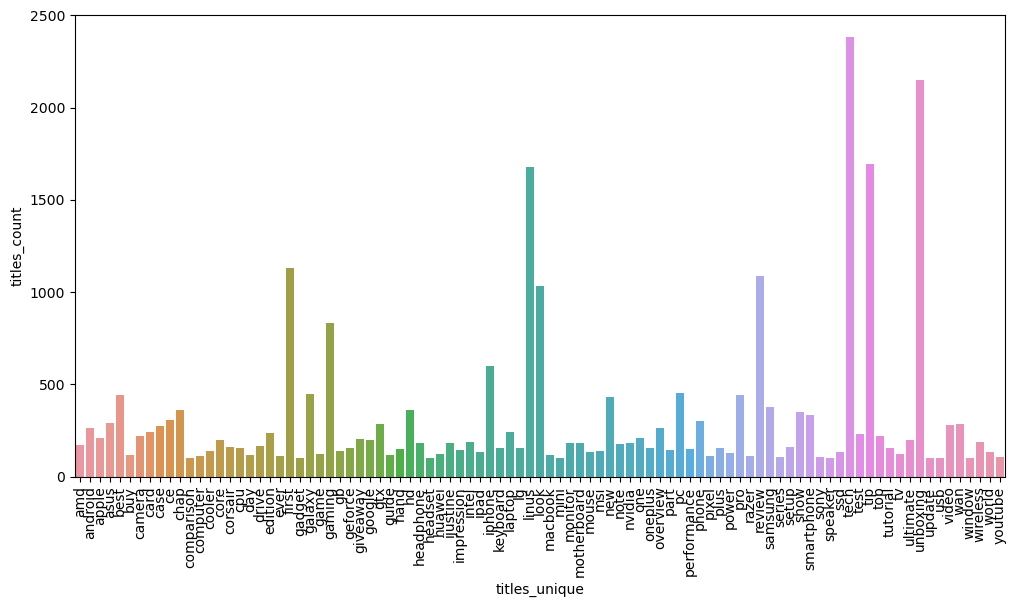

In [377]:
# plot the most commonly used words in titles
plt.figure(figsize=(12,4))
sns.barplot(x = titles_unique[titles_unique.titles_count>100].titles_unique, y = titles_unique[titles_unique.titles_count>100].titles_count)
plt.xticks(rotation=90)
plt.show()

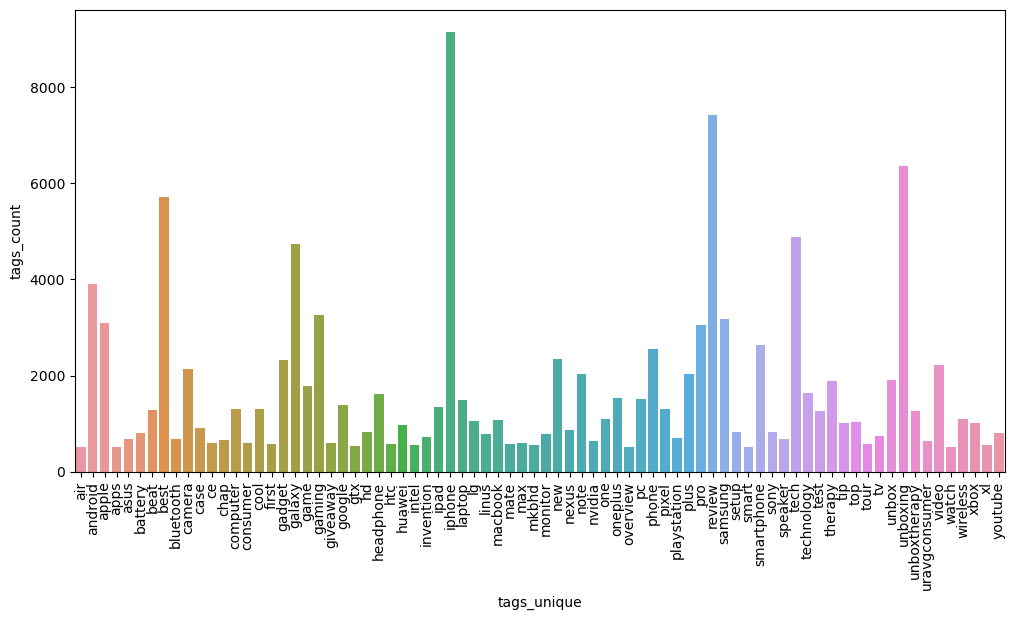

In [378]:
# plot the most commonly used words in tags
plt.figure(figsize=(12,4))
sns.barplot(x = tags_unique[tags_unique.tags_count>500].tags_unique, y = tags_unique[tags_unique.tags_count>500].tags_count)
plt.xticks(rotation=90)
plt.show()

In [379]:
# filter out the most common tech review words in titles and tags
titles_common = titles_unique[titles_unique.titles_count>100].titles_unique
tags_common = tags_unique[tags_unique.tags_count>500].tags_unique.values

### Filter tech review videos depending on its title and tags

In [421]:
# select only the features 'channel_id','display_id','duration','tags','title'
yt_tech_review = yt_metadata[['channel_id','display_id','duration','tags','title']]

# initialize tqdm for pandas
tqdm.pandas()

# count the number of occurances of the most commonly used words in tags and titles in the tags and title of each video
yt_tech_review['tags_occurances_count'] = yt_tech_review.tags.progress_apply(lambda tags: sum([True if tag in tags else False for tag in tags_common]))
yt_tech_review['title_occurances_count'] = yt_tech_review.title.progress_apply(lambda title: sum([True if word_common in title else False for word_common in titles_common]))

100%|█████████████████████████████████████████████████████████████████████| 2403004/2403004 [00:45<00:00, 52634.68it/s]


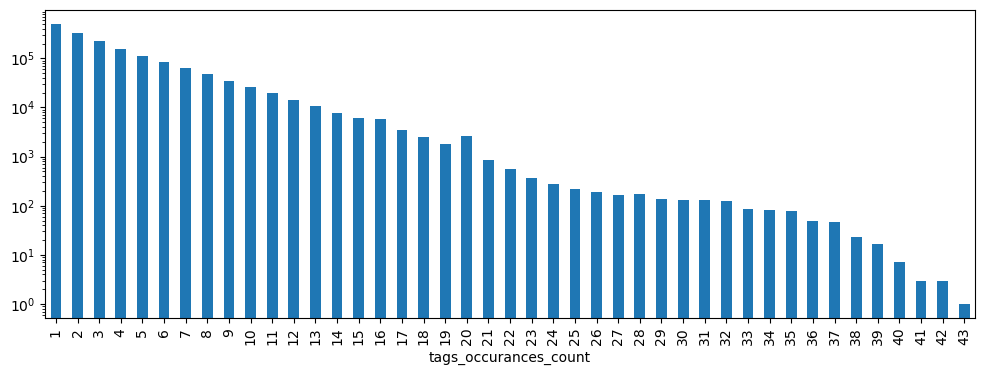

In [422]:
# plot the number of occurances of the most commonly used words in tags
plt.figure(figsize=(12,4))
yt_tech_review[yt_tech_review.tags_occurances_count>0].groupby('tags_occurances_count')['display_id'].count().plot(kind='bar')
plt.yscale('log')
plt.show()

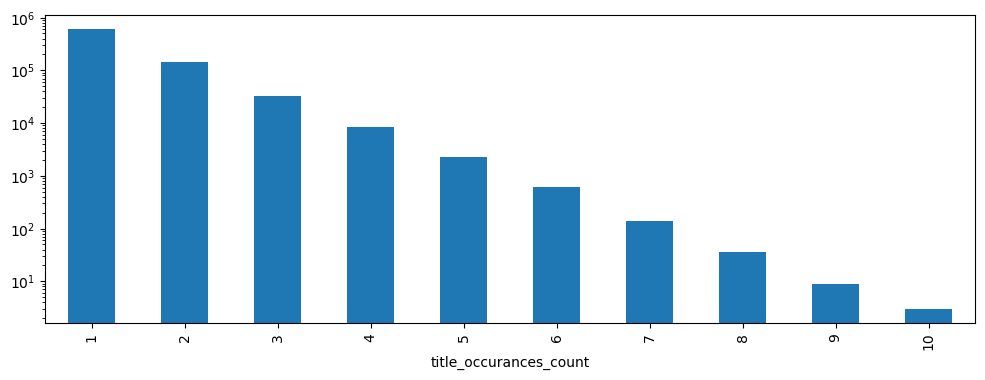

In [423]:
# plot the number of occurances of the most commonly used words in titles
plt.figure(figsize=(12,4))
yt_tech_review[yt_tech_review.title_occurances_count>0].groupby('title_occurances_count')['display_id'].count().plot(kind='bar')
plt.yscale('log')
plt.show()

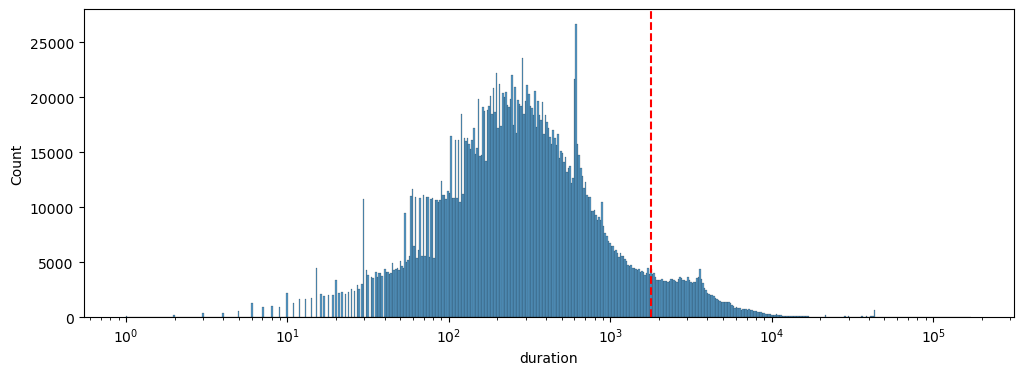

In [424]:
# plot the duration of videos
plt.figure(figsize=(12,4))
sns.histplot(x = yt_tech_review.duration, stat='count', log_scale=True)
plt.axvline(x=1800, color='red', linestyle='--')
plt.show()

In [477]:
# tech review videos only
tech_review_videos = yt_tech_review[(yt_tech_review.duration < 1800) & ((yt_tech_review.tags_occurances_count > 10) | (yt_tech_review.title_occurances_count > 3))]

# store tech review videos dataset
yt_metadata[yt_metadata.display_id.isin(tech_review_videos.display_id)].drop('categories',axis=1).reset_index(drop=True).to_pickle(PATH_TECH_VIDEOS,compression='gzip')

### Filter the tech review channels

In [426]:
# count the number of tech review videos per channel
count_tech_videos = tech_review_videos.groupby('channel_id',as_index=False)[['display_id']].count().rename({'display_id':'count_tech_videos'},axis=1)

# assign the number of tech review videos for each channel
df_tech_channels = pd.merge(df_channels.rename({'channel':'channel_id'},axis=1), count_tech_videos, how='left', on='channel_id')
df_tech_channels.loc[df_tech_channels.count_tech_videos.isna(), 'count_tech_videos'] = 0

# get the percentage of tech review videos
df_tech_channels['tech_videos_perc'] = df_tech_channels['count_tech_videos'] / df_tech_channels['videos_cc']

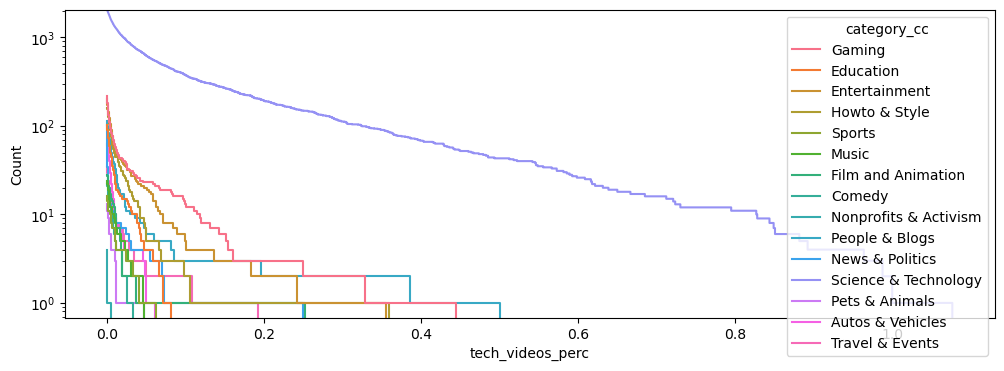

In [454]:
# plot the number of channels versus the percentage of tech review videos per channel for each category
plt.figure(figsize=(12,4))
sns.ecdfplot(x = df_tech_channels[df_tech_channels.tech_videos_perc > 0].tech_videos_perc, stat='count', complementary=True, hue=df_tech_channels.category_cc)
plt.yscale('log')
plt.show()

In [475]:
# tech review videos only
tech_review_channels = df_tech_channels[(df_tech_channels.tech_videos_perc > 0.01) & (df_tech_channels.channel_id.isin(yt_tech_review.channel_id.unique())) & (df_tech_channels.category_cc == 'Science & Technology')]

# store tech review channels dataset
tech_review_channels.reset_index(drop=True).to_pickle(PATH_TECH_CHANNELS,compression='gzip')